In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Log In - AgInjuryNews (1).xlsx - Sheet1 (1) - Log In - AgInjuryNews (1).xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:18].values)
Y = pd.DataFrame(dataset.iloc[:,18:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X,Y,test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.reshape(2735,18,1)
X_test.reshape(684,18,1)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

features = pd.DataFrame(dataset.iloc[:,:18])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0      3   2   2  25   0   3  10   0   0   0   0   0   0   0   0   0   1   1
1      3   3   1  61   0   3  10   0   0   0   0   0   0   0   0   0   7   1
2      3   3   1  65   0   3  10   0   0   0   0   0   0   0   0   0   6   1
3      3   2   1  49   0   3  10   0   0   0   1   0   0   0   0   0   5   1
4      3   1   1  54   0   5   2   1   1   0   0   0   0   0   0   1   5   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3414   1   2   1  57   0   6   7   0   0   0   0   0   0   0   0   0   1   4
3415   1   1   1  24   0   3   7   0   0   0   0   0   0   0   0   0   1   4
3416   1   1   1  50   0   3  10   0   0   0   0   0   0   0   0   0   6   4
3417   1   2   1  58   0   3   9   0   0   0   0   0   0   0   0   0   6   4
3418   1   2   1   3   0   4  10   0   0   0   0   0   0   0   0   0   5   4

[3419 rows x 18 columns]
      0
0     0
1     1
2     1
3     0
4     1
..

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention, Dropout, Add, LayerNormalization,Input 
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [3]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([attention_output, inputs])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed Forward Network
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return Add()([ff_output, attention_output])

  # Build the model
  inputs = Input(shape=(18, 1))
  head_size = hp.Int('units', min_value=32, max_value=128, step=16)
  x = transformer_block(inputs, head_size=head_size, num_heads=4, ff_dim=64, dropout=0.1)
  x = transformer_block(x, head_size=head_size, num_heads=4, ff_dim=64, dropout=0.1)

  # Flatten and Dense layers
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.5)(x)
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4,1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [4]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape = (18,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [5]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='transformer_hyper',
                     project_name='transfomer_hyper')


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.5082266926765442

Best val_accuracy So Far: 0.6014625430107117
Total elapsed time: 00h 01m 28s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 1e-05.



In [7]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=500, validation_split=0.2)

Epoch 1/500
69/69 [==============================] - 1s 7ms/step - loss: 0.6634 - accuracy: 0.6060 - val_loss: 0.6877 - val_accuracy: 0.5777
Epoch 2/500
69/69 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6051 - val_loss: 0.6876 - val_accuracy: 0.5777
Epoch 3/500
69/69 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.6047 - val_loss: 0.6875 - val_accuracy: 0.5759
Epoch 4/500
69/69 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6047 - val_loss: 0.6873 - val_accuracy: 0.5759
Epoch 5/500
69/69 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6033 - val_loss: 0.6872 - val_accuracy: 0.5777
Epoch 6/500
69/69 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6033 - val_loss: 0.6871 - val_accuracy: 0.5777
Epoch 7/500
69/69 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6015 - val_loss: 0.6869 - val_accuracy: 0.5759
Epoch 8/500
6

In [8]:
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [9]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, Y_train, epochs=467, validation_split=0.2)

Epoch 1/467
69/69 [==============================] - 5s 15ms/step - loss: 0.6821 - accuracy: 0.3588 - val_loss: 0.6821 - val_accuracy: 0.3985
Epoch 2/467
69/69 [==============================] - 1s 9ms/step - loss: 0.6820 - accuracy: 0.3592 - val_loss: 0.6820 - val_accuracy: 0.3985
Epoch 3/467
69/69 [==============================] - 0s 6ms/step - loss: 0.6818 - accuracy: 0.3592 - val_loss: 0.6819 - val_accuracy: 0.3985
Epoch 4/467
69/69 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.3597 - val_loss: 0.6818 - val_accuracy: 0.3985
Epoch 5/467
69/69 [==============================] - 0s 7ms/step - loss: 0.6816 - accuracy: 0.3601 - val_loss: 0.6817 - val_accuracy: 0.3985
Epoch 6/467
69/69 [==============================] - 1s 8ms/step - loss: 0.6815 - accuracy: 0.3597 - val_loss: 0.6816 - val_accuracy: 0.3985
Epoch 7/467
69/69 [==============================] - 0s 6ms/step - loss: 0.6813 - accuracy: 0.3601 - val_loss: 0.6815 - val_accuracy: 0.4004
Epoch 8/467


In [10]:
res = hypermodel.predict(X_test)
res.round()
actual = []
for num in res:
    if num>0.5:
        actual.append(1)
    else:
        actual.append(0)
from sklearn.metrics import classification_report
print(classification_report(Y_test,actual,digits=6))

22/22 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0   0.374214  0.466667  0.415358       255
           1   0.628415  0.536131  0.578616       429

    accuracy                       0.510234       684
   macro avg   0.501315  0.501399  0.496987       684
weighted avg   0.533647  0.510234  0.517752       684



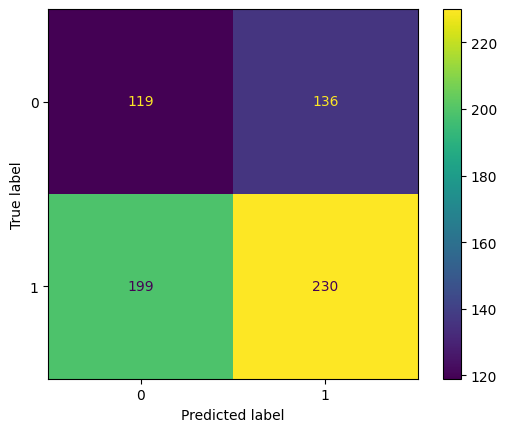

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, actual)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()